# Compute trophoblast diffusion pseudotime

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scrabbit

sc.set_figure_params(dpi=150,dpi_save=300)
sc.settings.figdir = "plots/"

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
r_data = sc.read_h5ad("data-in/r_anndata.h5ad")
r_data

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 146133 × 30725
    obs: 'cell', 'barcode', 'sample', 'stage', 'dissection', 'doub.density', 'stripped', 'sizeFactor', 'singler', 'celltype', 'leiden_res1', 'leiden_res1_5', 'leiden_res2', 'leiden_res2_5', 'leiden_res3', 'leiden_res5', 'leiden_res6', 'leiden_res7', 'leiden_res8', 'leiden_res10'
    var: 'ensembl_id', 'gene_name', 'is_human_align_gene'
    uns: 'celltype_colors', 'dissection_colors', 'draw_graph', 'leiden', 'neighbors', 'singler_colors', 'stage_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

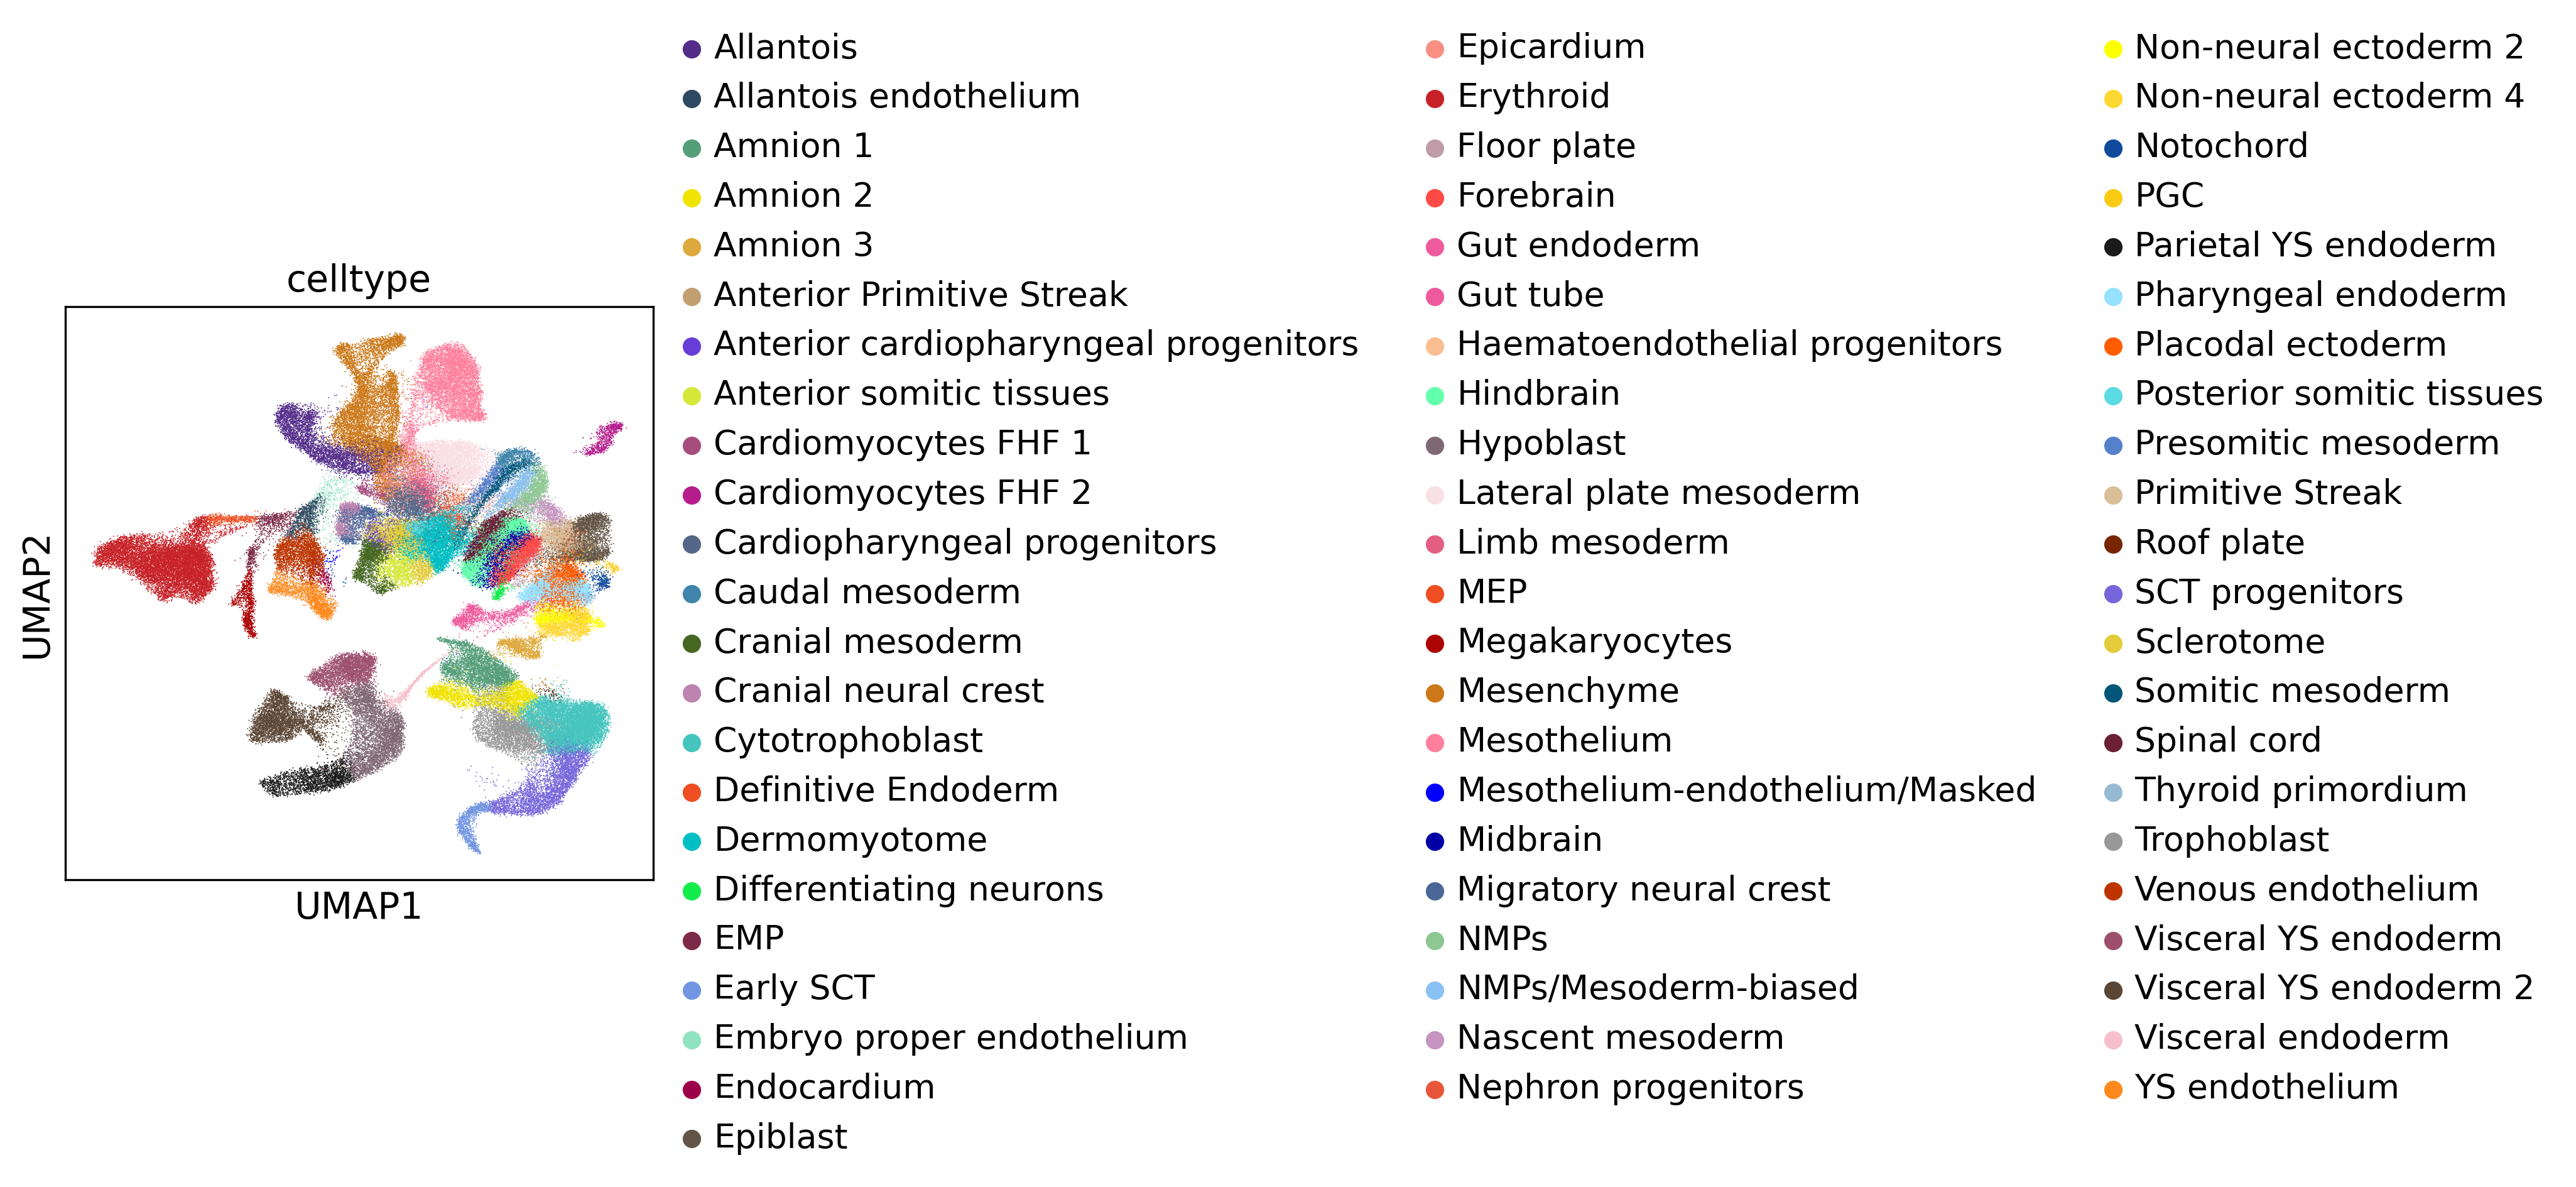

In [4]:
sc.pl.umap(r_data, color="celltype")

In [104]:
# Subset ExE cell types
r_ecto = r_data[r_data.obs["celltype"].isin(["Trophoblast","Syncytiotrophoblast", 
                                               "Syncytiotrophoblast progenitors", "Cytotrophoblast", "Amnion 1",
                                            "Amnion 2", "Amnion 3"])]

In [110]:
# Abbreviate syncytiotrophoblast
r_ecto.obs["celltype"] = r_ecto.obs["celltype"].cat.rename_categories({"Syncytiotrophoblast progenitors": "SCT progenitors",
                                         "Syncytiotrophoblast": "Early SCT"})

Trying to set attribute `.obs` of view, copying.


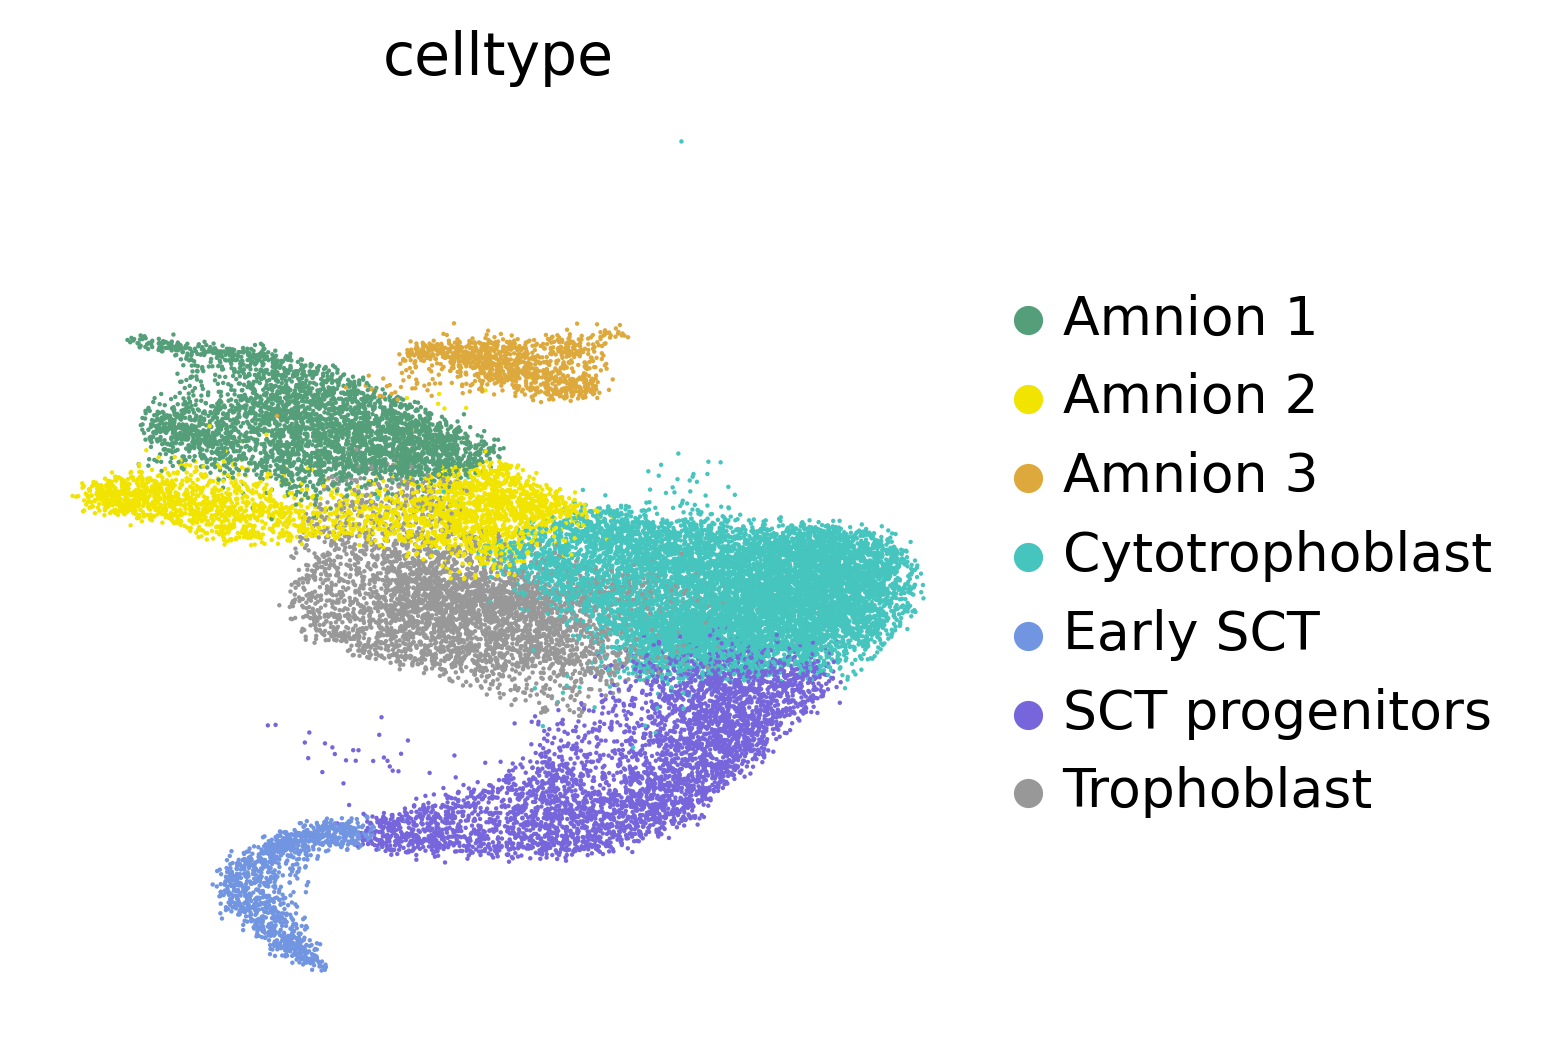

In [112]:
# Figure 3A
sc.pl.umap(r_ecto, color="celltype", frameon = False, save = "_tropho_celltypes.pdf")

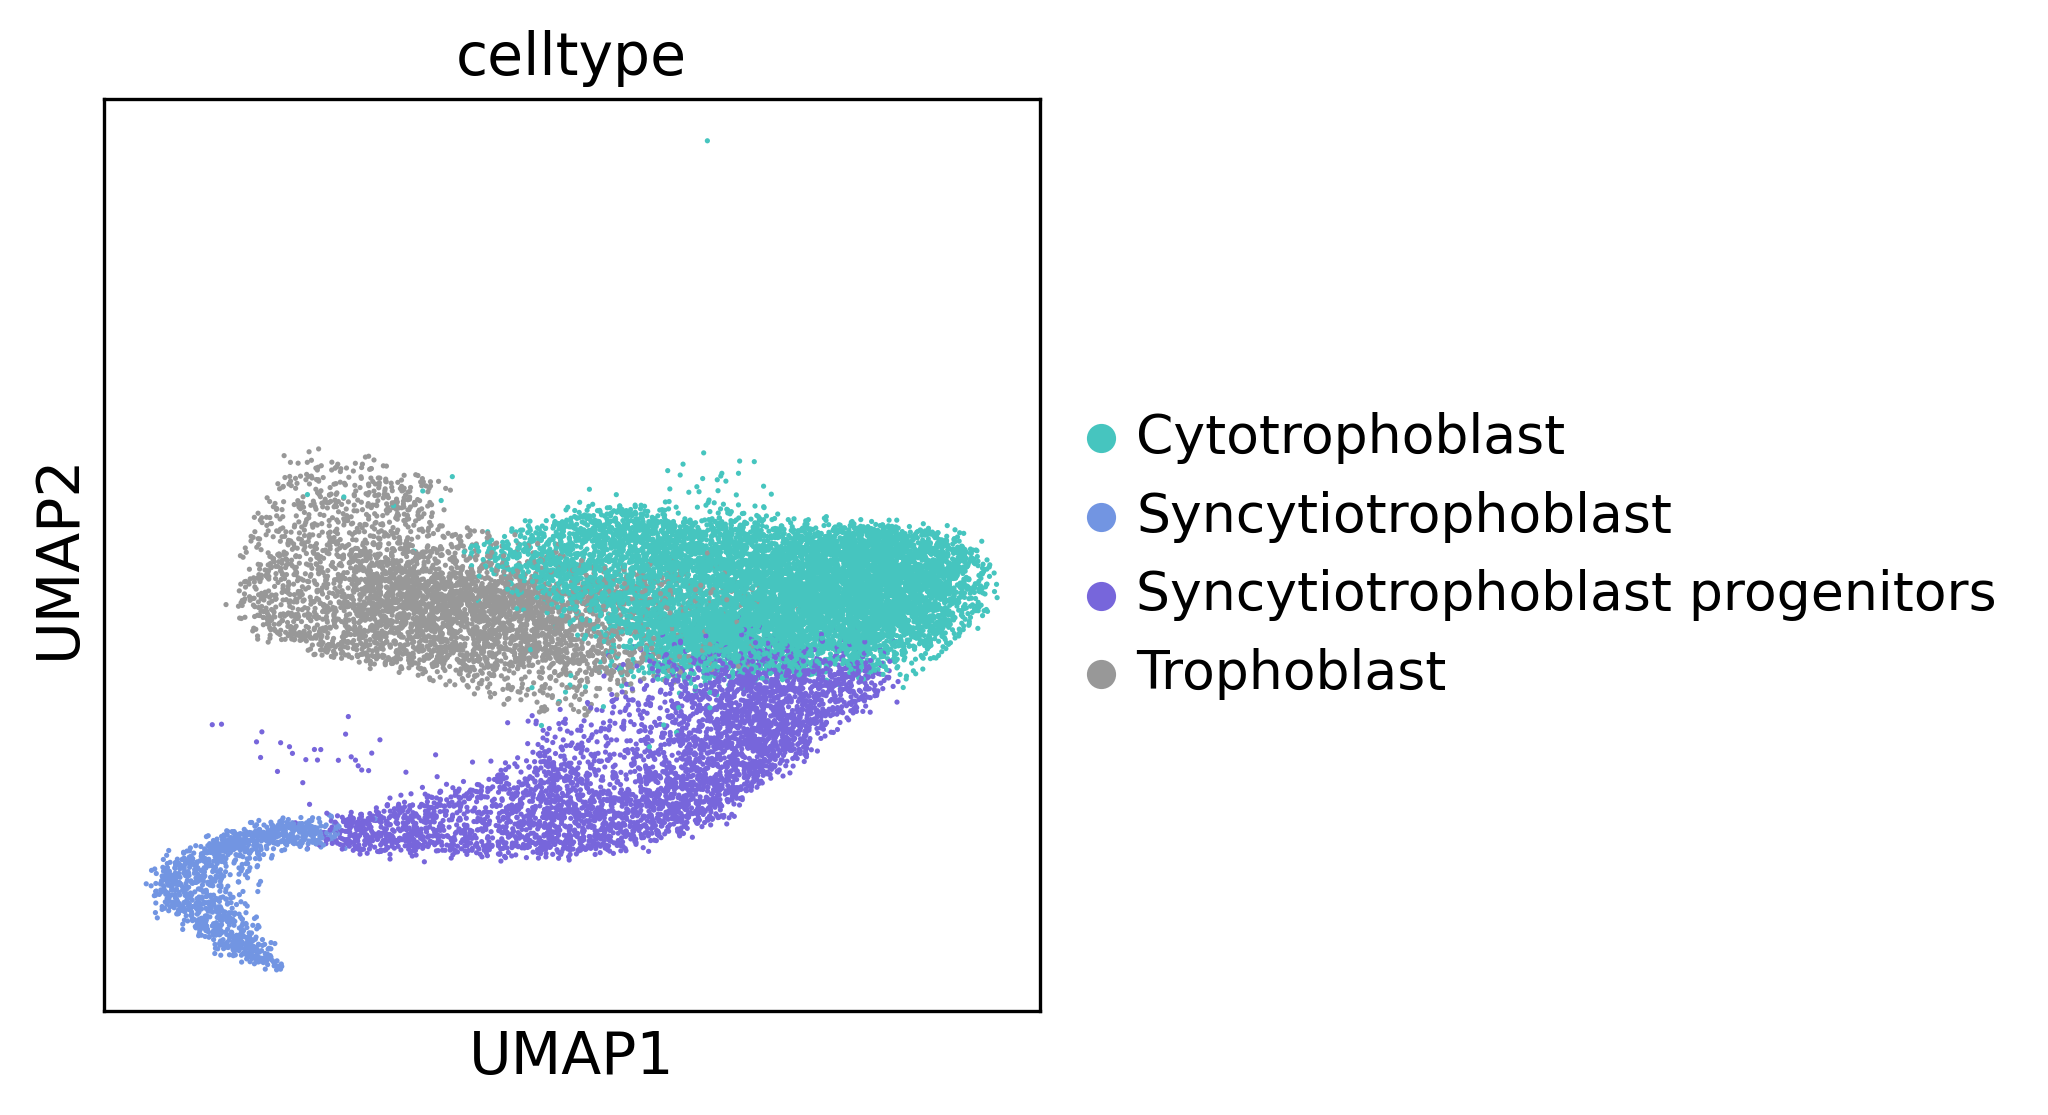

In [12]:
# Subset trophoblast cells
r_tropho = r_data[r_data.obs["celltype"].isin(["Trophoblast","Syncytiotrophoblast", 
                                               "Syncytiotrophoblast progenitors", "Cytotrophoblast"])]
sc.pl.umap(r_tropho,color="celltype")

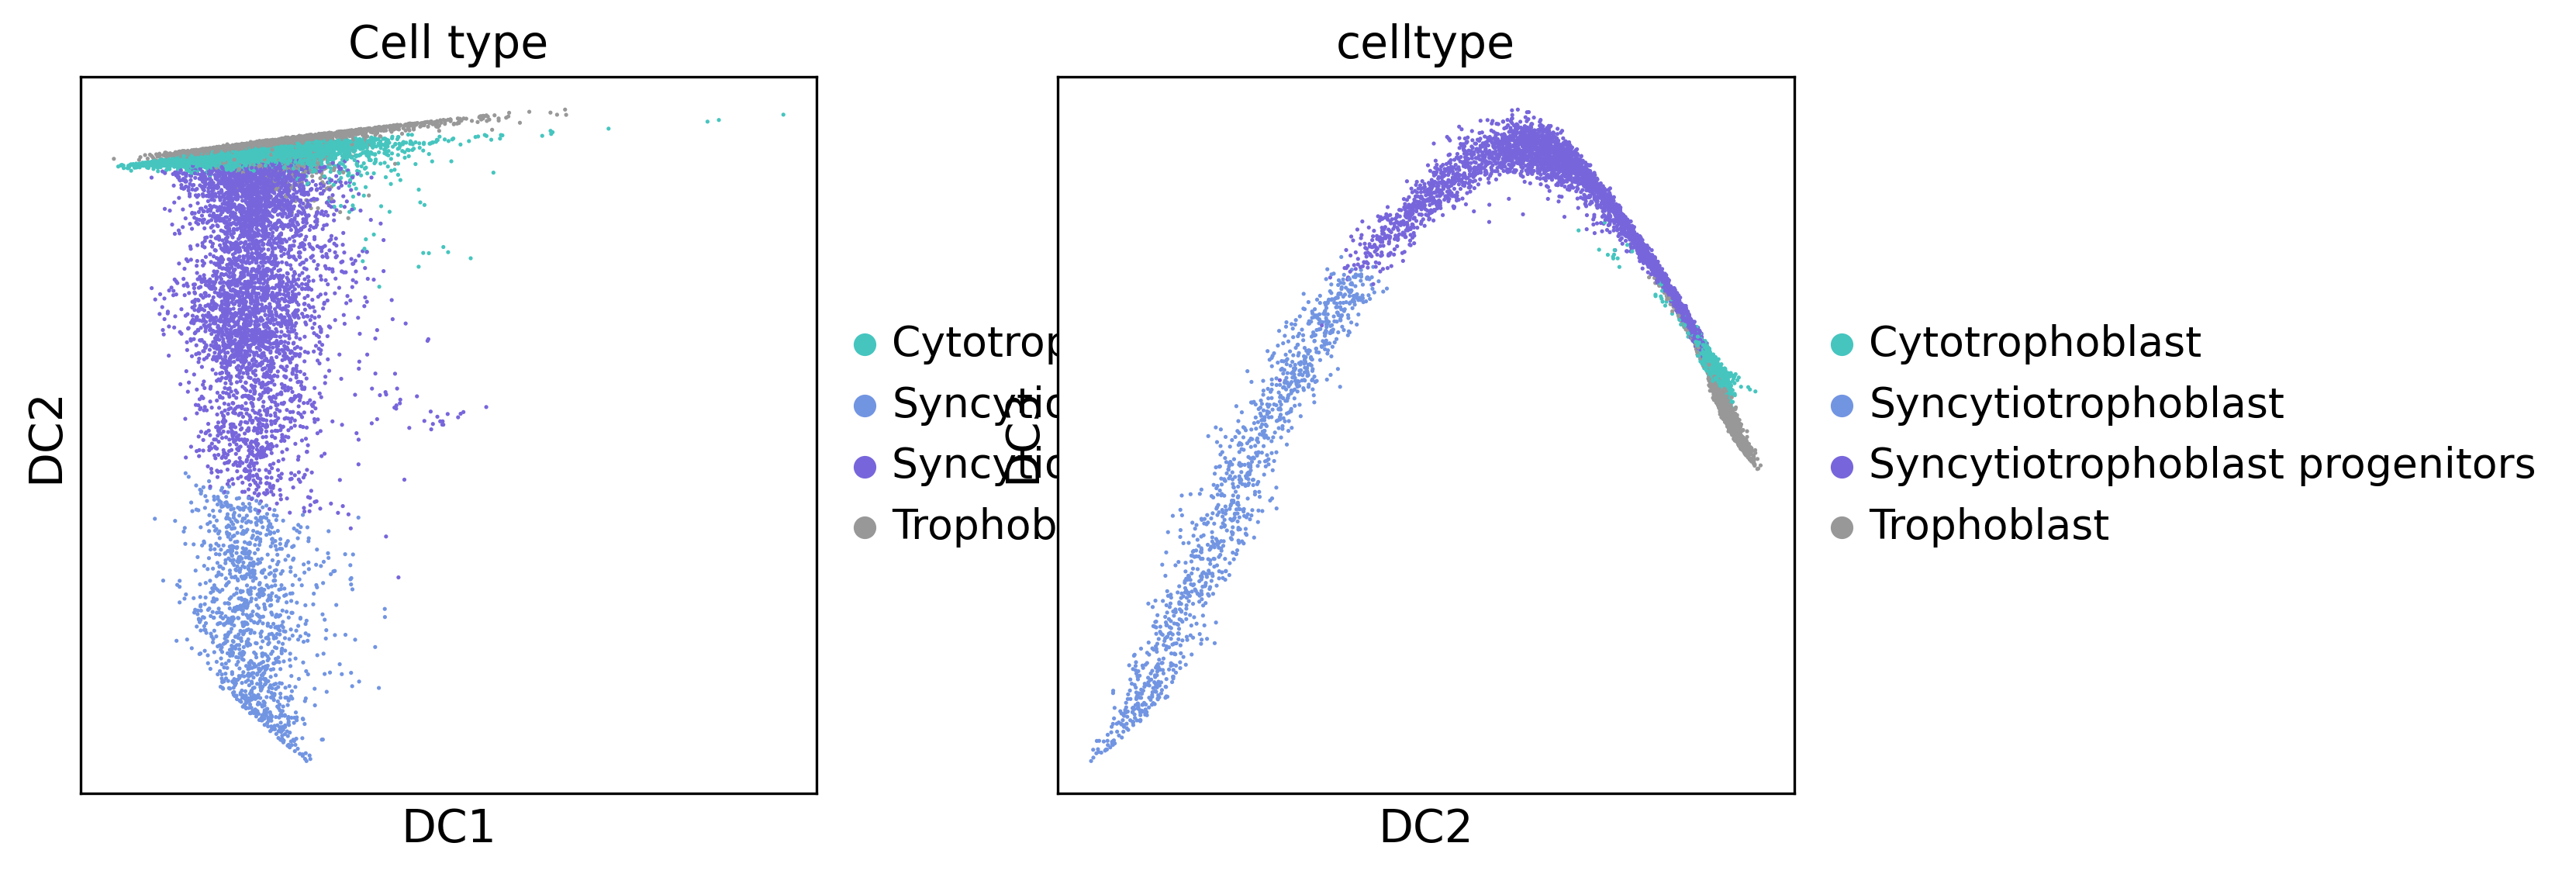

In [14]:
# Run diffusion map
sc.tl.diffmap(r_tropho, n_comps=30)
sc.pl.diffmap(r_tropho, color=["celltype"], title="Cell type", components=['1,2','2,3'])

In [17]:
# Get diffmap coordinates of GD7 tropho cells
gd7_tropho = (r_tropho.obs["celltype"]  == "Trophoblast") & (r_tropho.obs["stage"]  == "GD7")
gd7_obs = r_tropho.obs[gd7_tropho]
gd7_diffmap = r_tropho.obsm["X_diffmap"][gd7_tropho][:,1] 

# Choose gd7 tropho cell with largest diffmap x coordinate
gd7_root_index = np.argmax(gd7_diffmap, axis=0)
root_cell = gd7_obs.index[gd7_root_index]
root_index = r_tropho.obs.index.get_loc(root_cell)

r_tropho.uns['iroot'] = root_index

/hps/software/users/marioni/dkeitley/miniconda3/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'root_cell' as categorical
/hps/software/users/marioni/dkeitley/miniconda3/envs/pyenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


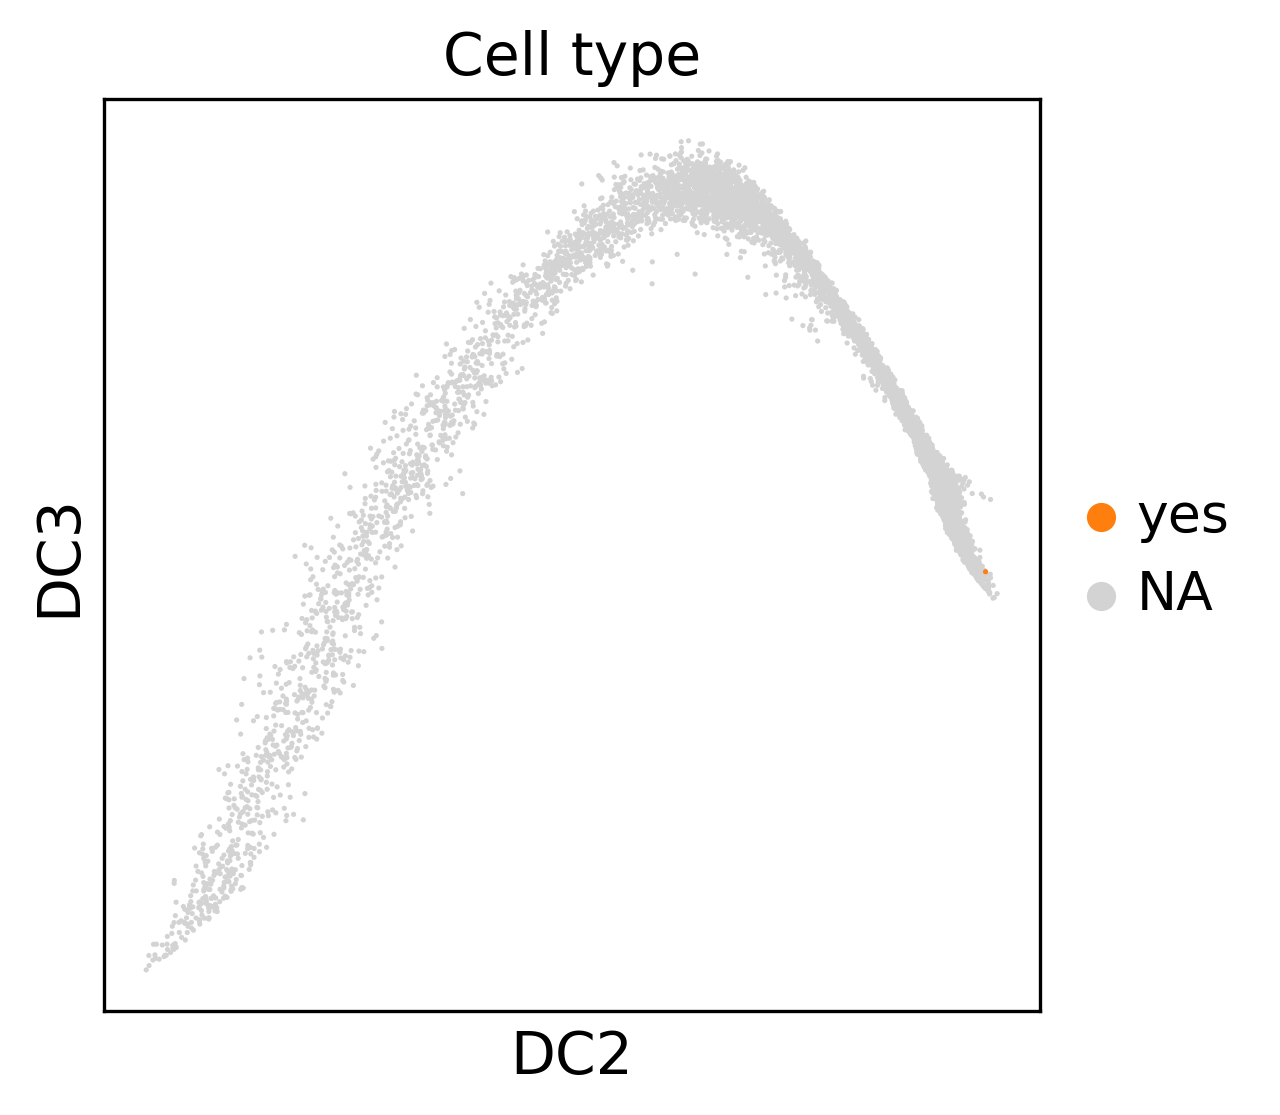

In [18]:
# Highlight root cell
r_tropho.obs["root_cell"] = ["Root cell" if x == root_index else "NA" for x in range(r_tropho.obs.shape[0])]
sc.pl.diffmap(r_tropho, color=["root_cell"], groups="yes", title="Cell type",components=['2,3'])

In [19]:
# Run diffusion pseudotime
sc.tl.dpt(r_tropho, n_dcs=30, n_branchings = 0)

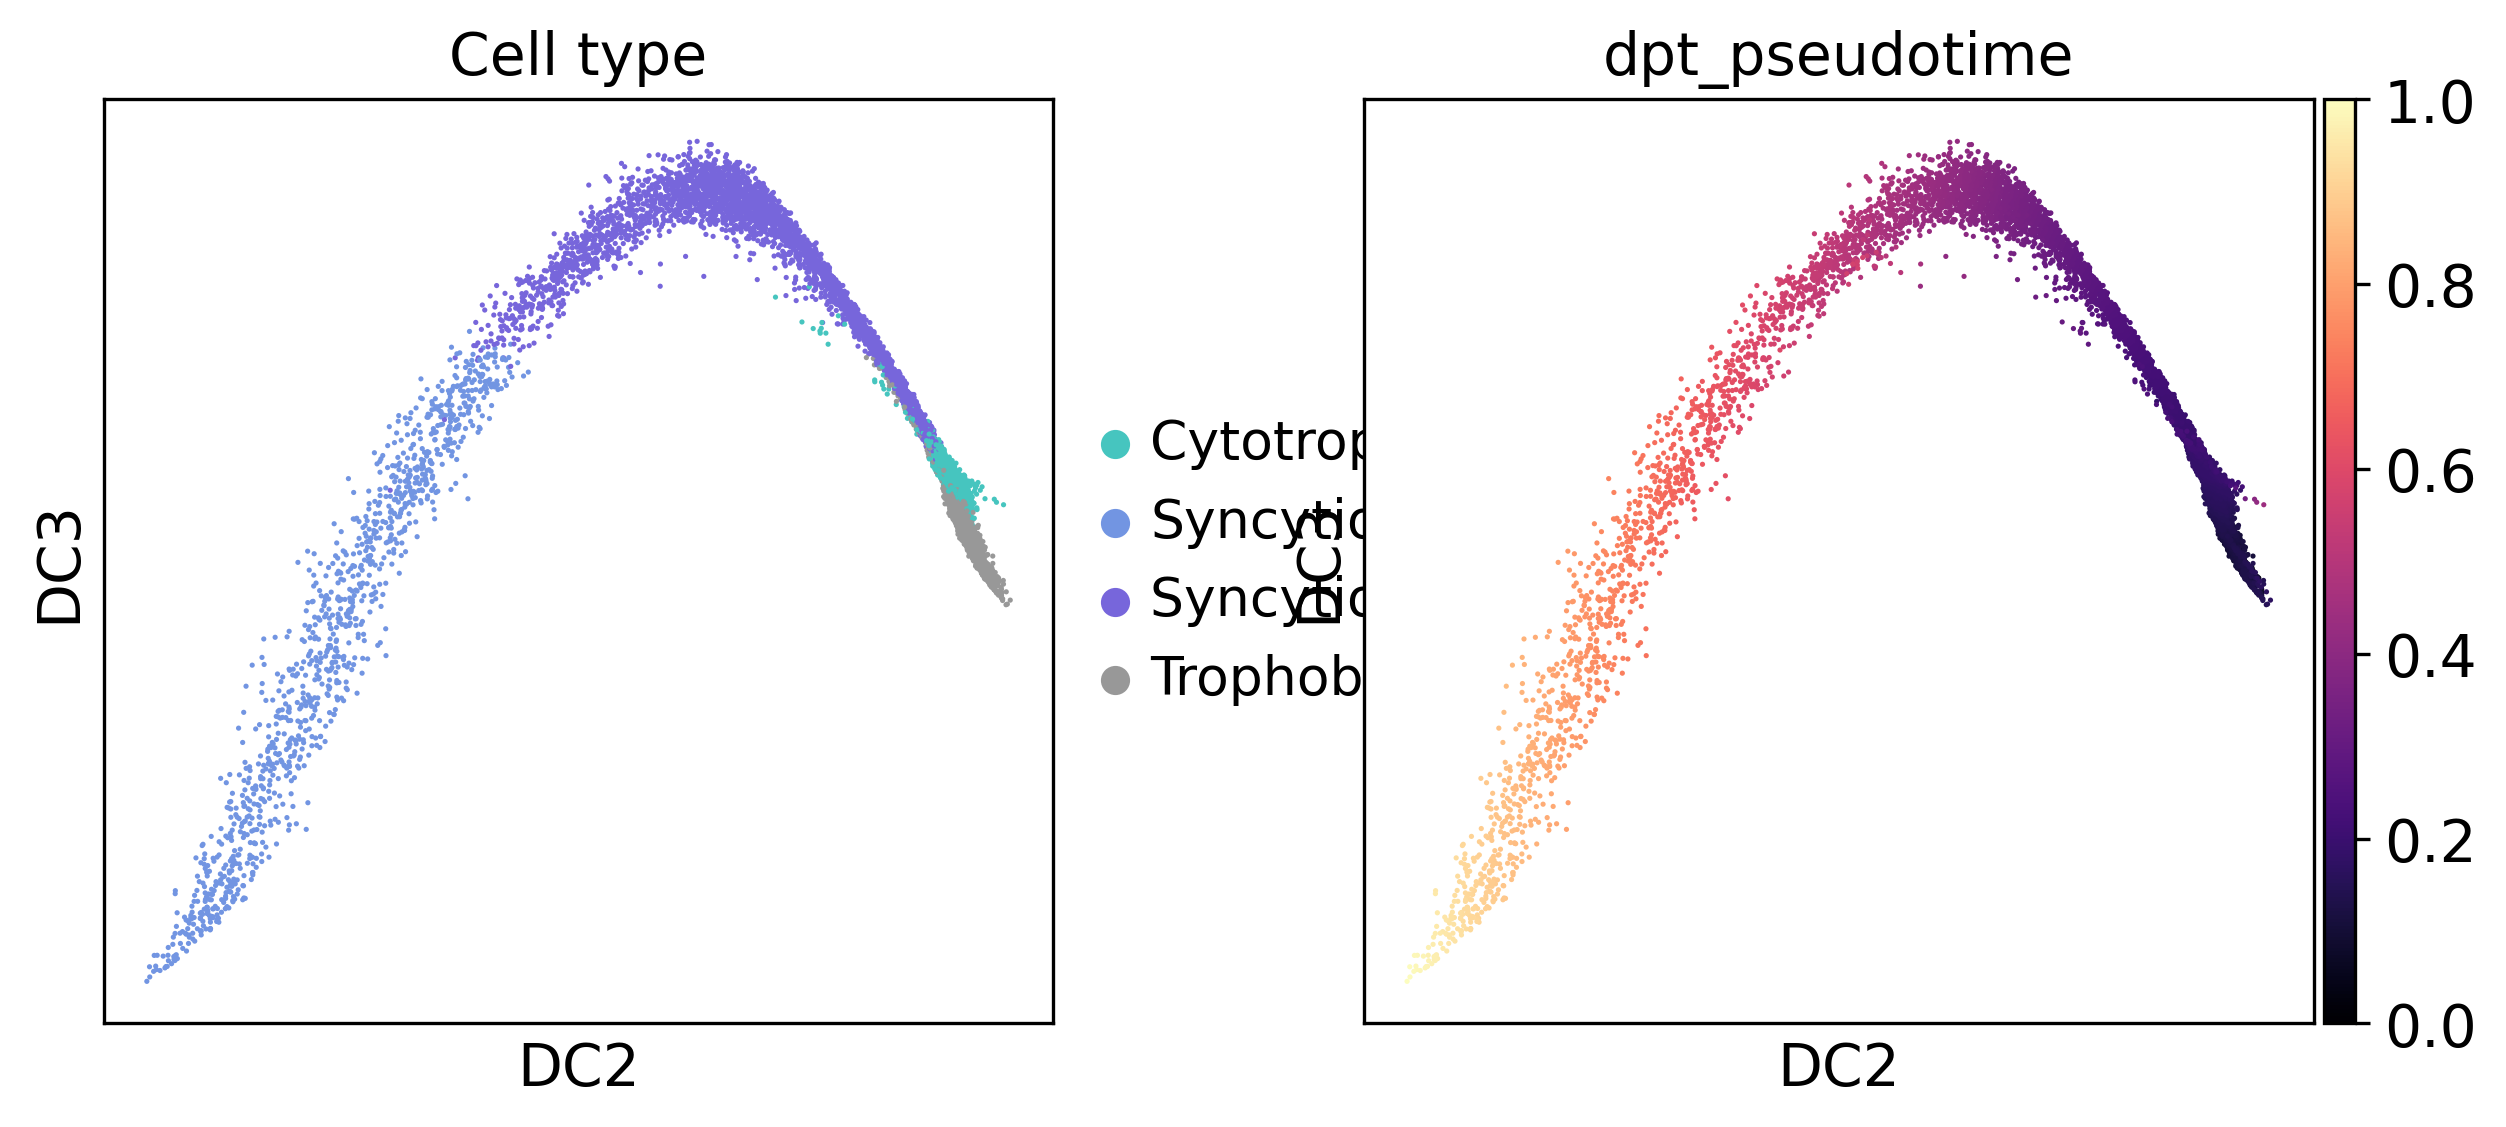

In [21]:
sc.pl.diffmap(r_tropho, color=["celltype", "dpt_pseudotime"], 
              components = ['2,3'],
              title="Cell type",color_map = "magma")

In [ ]:
# Export diffmap and dpt
r_tropho.obs["dpt_pseudotime"].to_csv("../data-out/trajectory_analysis/rabbit/trophoblast_dpt_pseudotime.tsv", sep="\t")
pd.DataFrame(r_tropho.obsm["X_diffmap"]).to_csv("../data-out/trajectory_analysis/rabbit/trophoblast_diffmap.tsv", sep="\t", index=False, header=False)

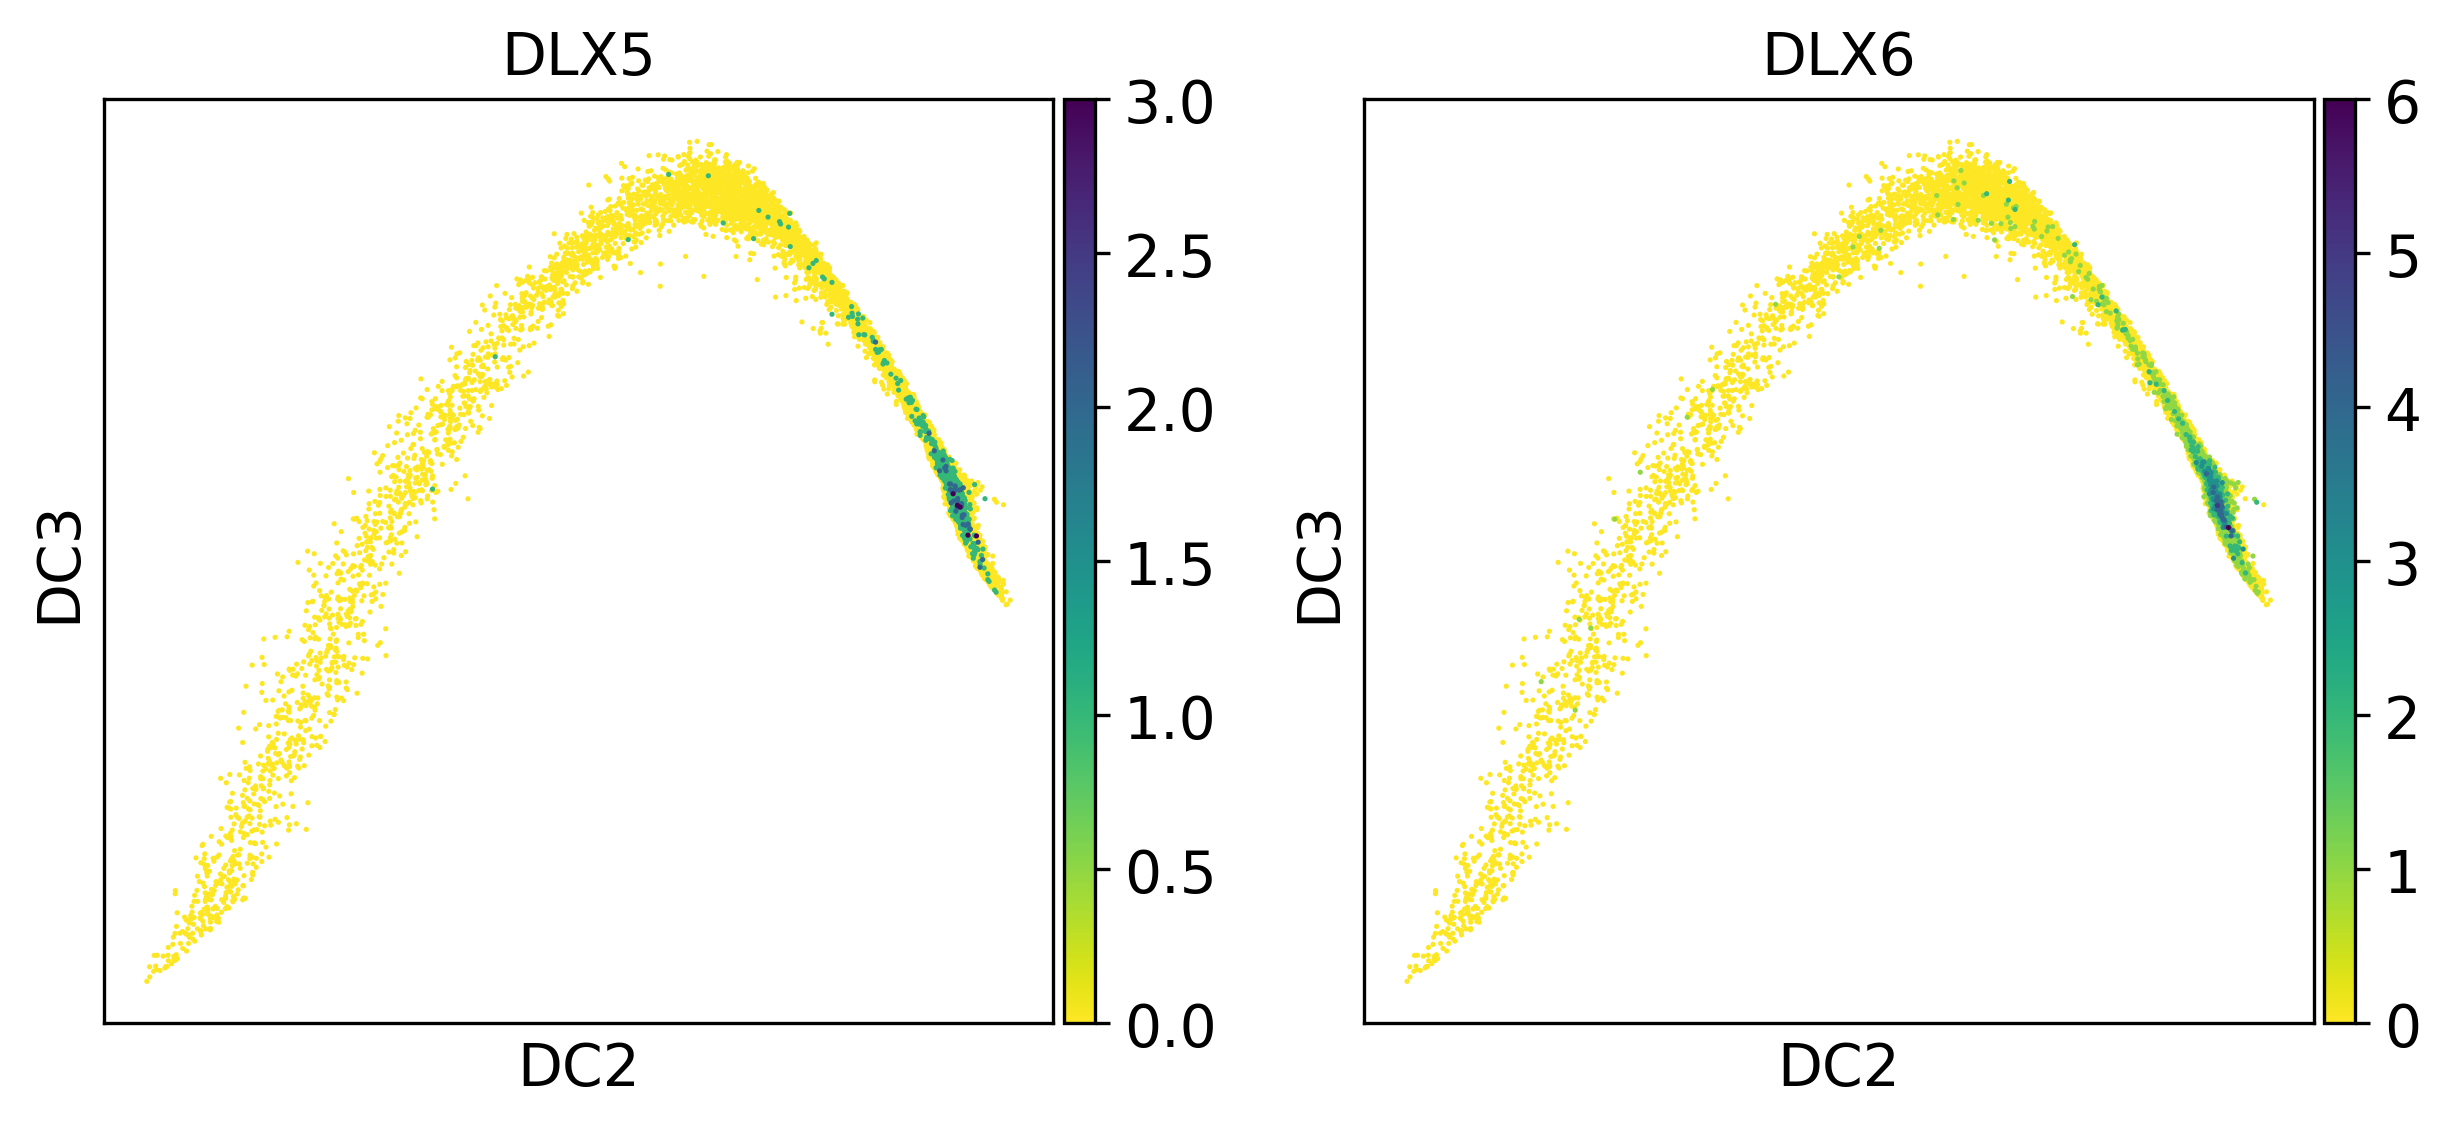

In [102]:
# Figure 3Di
sc.pl.diffmap(r_tropho, color = ["DLX5","DLX6"], color_map = "viridis_r",
              components = ['2,3'], save = "_DLX5_DLX6.pdf")

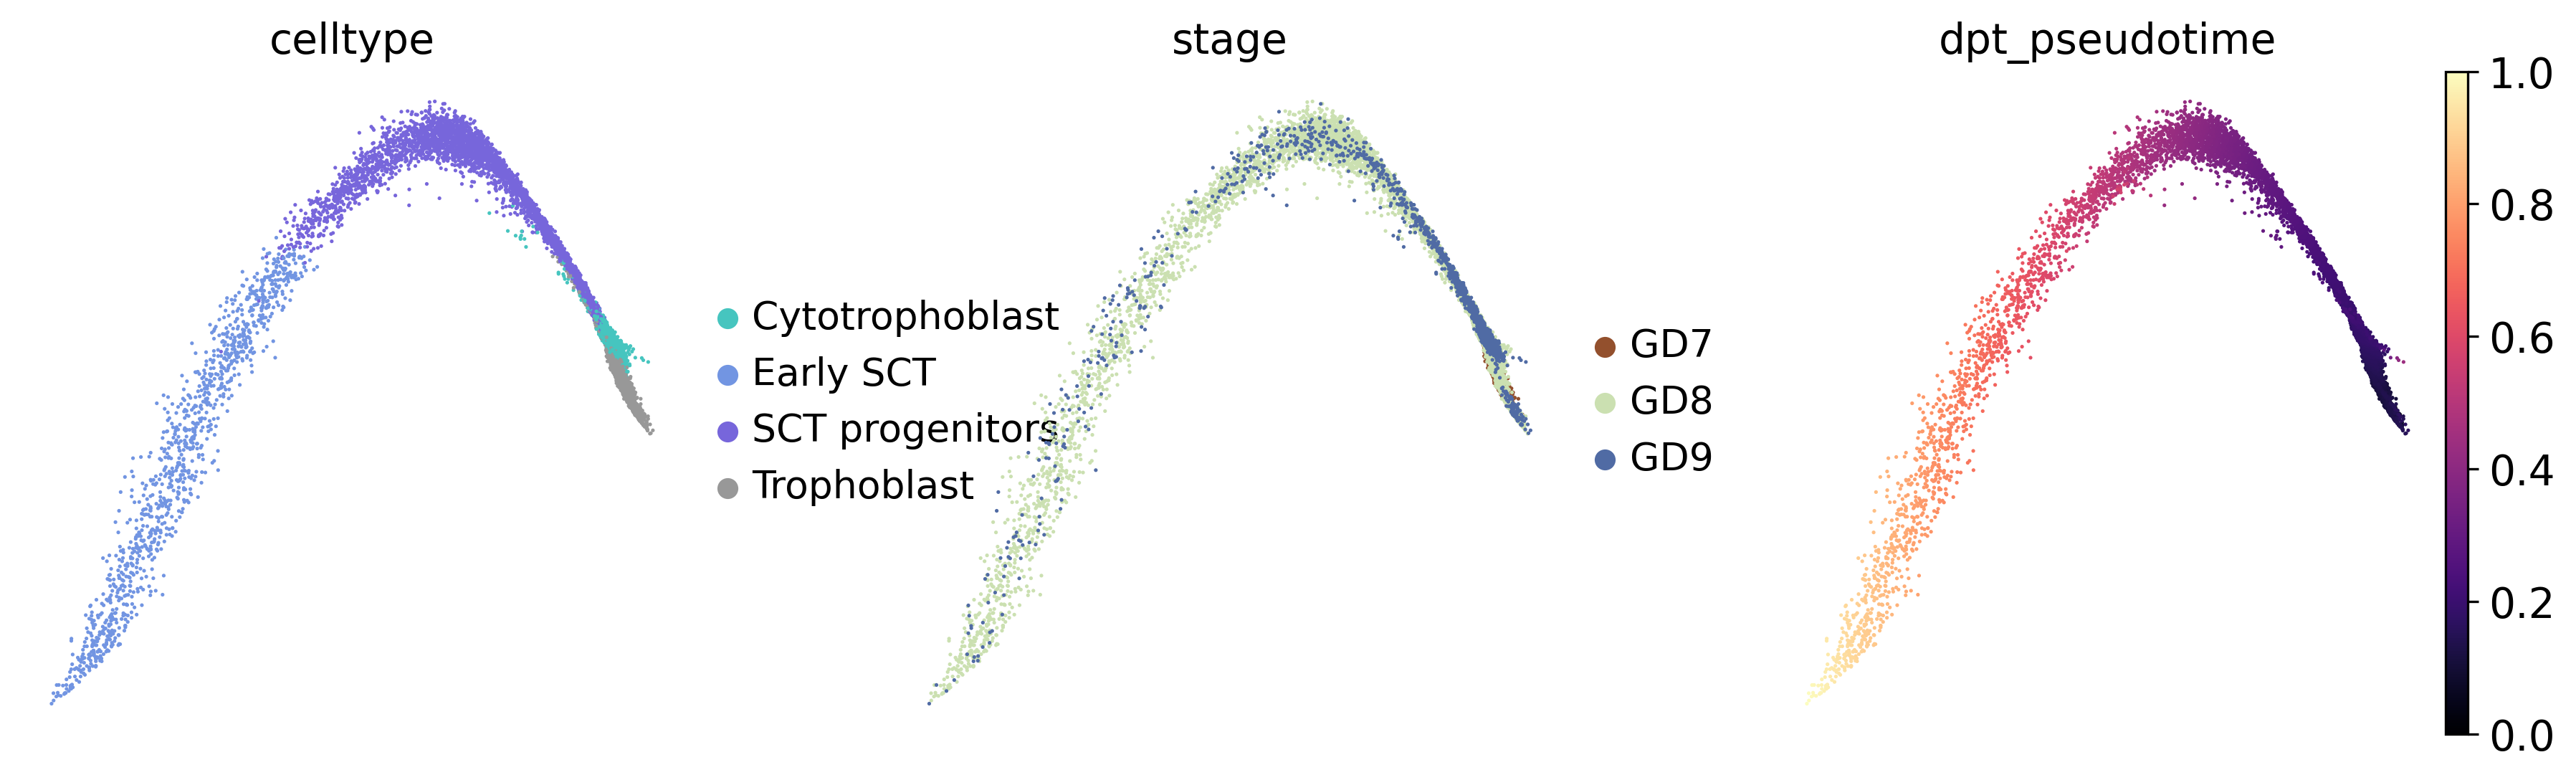

In [115]:
# Figure 3B
r_tropho.obs["celltype"] = r_tropho.obs["celltype"].cat.rename_categories({"Syncytiotrophoblast progenitors": "SCT progenitors",
                                         "Syncytiotrophoblast": "Early SCT"})

r_tropho.uns["stage_colors"] = ["#93502D", "#CBE0B1", "#506BA4"]
sc.pl.diffmap(r_tropho, color = ["celltype", "stage", "dpt_pseudotime"], color_map = "magma",
              components = ['2,3'], frameon = False, save = "_celltype_stage_pseudo.pdf")

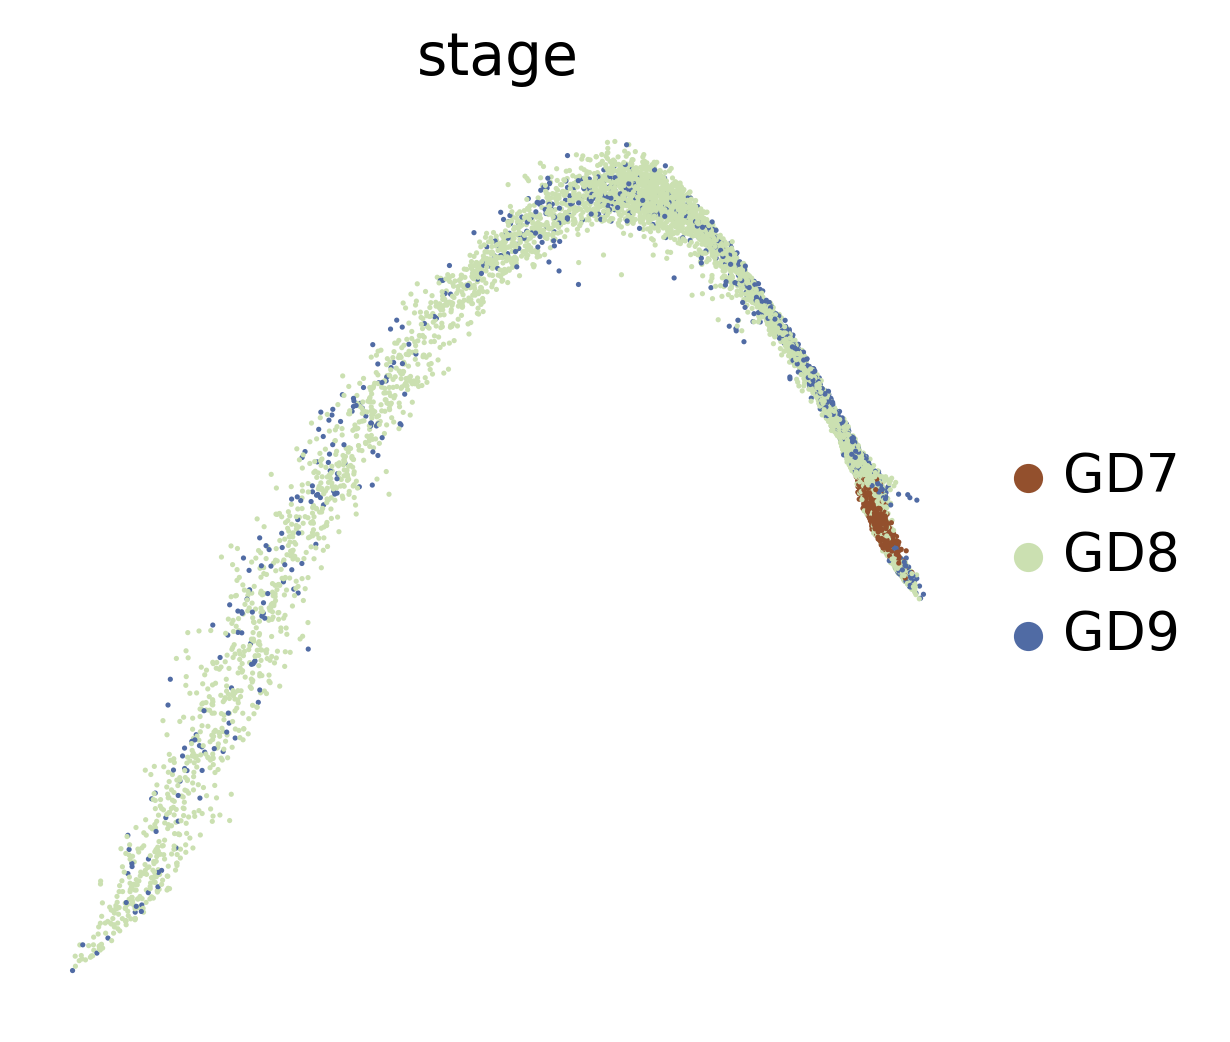

In [130]:
# Randomise plot order to make GD7 cells clearer 
r_tropho.obs["stage_rev"] = r_tropho.obs["stage"].cat.reorder_categories(['GD9', 'GD8','GD7'])
r_rand = r_tropho[np.random.permutation(r_tropho.n_obs),:]
sc.pl.diffmap(r_rand, color = ["stage"], 
              components = ['2,3'], frameon = False, save = "_stage.pdf")